# The TLS211_PAT_PUBLN Table 

Welcome to a comprehensive exploration of one of the key tables in the PATSTAT database: the Publication Table (``TLS211_PAT_PUBLN``). The ``TLS211_PAT_PUBLN`` table is a critical component of the EPO’s PATSTAT database, containing key bibliographic information related to patent publications. This table stores data from over 90 countries, including patent documents and utility model documents, reflecting the various stages of patent processing. These publications are snapshots of a patent application's progress, from initial filing through to grant, providing comprehensive insights into the lifecycle of patent applications.

Each record in the ``TLS211_PAT_PUBLN`` table represents a unique patent publication and contains essential information such as the publication authority, publication number, kind code, language and publication date. These elements are typically found on the first page of a printed patent document, helping to identify the publication. The table also includes two supplementary data points:

1. ``PUBLN_FIRST_GRANT``: Indicates whether the publication is the first granted version of the patent.
2.  ``PUBLN_CLAIMS``: Stores the number of claims associated with the publication (available for select patent authorities).

This table is directly linked to the ``TLS201_APPLN`` table through the ``APPLN_ID``, ensuring that the bibliographic data can be connected back to the patent application. Furthermore, it supports a detailed understanding of the publication process, including identifying amendments and tracking different kinds of publication events, such as applications, grants, and search reports.

In addition, ``TLS211_PAT_PUBLN`` includes a mechanism for handling artificial publications—cases where a cited document is missing from the DOCDB but is assumed to exist due to its citation. These artificial entries are given unique ``PUBLN_IDs`` in a reserved range and are assigned a default publication date of '**9999-12-31**', allowing them to be identified and analysed separately. In fact, PATSTAT data does not contain any NULL values and in fact all attributes may be defined as NOT NULL. Depending on the data type / domain, PATSTAT represents missing values like this:

  - Missing values in attributes of type date are represented as '**9999-12-31**'.

In [1]:
from epo.tipdata.patstat import PatstatClient
from epo.tipdata.patstat.database.models import (
    TLS201_APPLN,
    TLS206_PERSON,
    TLS211_PAT_PUBLN,
    TLS227_PERS_PUBLN
)
from sqlalchemy import and_, case, func, select

# Initialise the PATSTAT client
patstat = PatstatClient(env="TEST")

# Access ORM
db = patstat.orm()

## Key Fields in the TLS211_PAT_PUBLN Table

### PAT_PUBLN_ID and APPLN_ID

In the ``TLS211_PAT_PUBLN`` table, the primary key is ``PAT_PUBLN_ID``, and the foreign key is ``APPLN_ID``.

1. Primary Key: ``PAT_PUBLN_ID``

    - ``PAT_PUBLN_ID`` serves as the primary key for this table, uniquely identifying each patent publication. Each record in the ``TLS211_PAT_PUBLN`` table corresponds to a specific patent publication, and the ``PAT_PUBLN_ID`` ensures that there is no duplication of records. This field is a unique identifier for every publication event (whether application publication, grant, or other types), providing a direct reference point for accessing the bibliographic details of each document.

  
2. Foreign Key: ``APPLN_ID``

    - The ``APPLN_ID`` is the foreign key that links the ``TLS211_PAT_PUBLN`` table to the ``TLS201_APPLN`` table, which contains the details of the corresponding patent application. This relationship is crucial because a patent publication is directly tied to the patent application it originates from. The ``APPLN_ID`` in ``TLS211_PAT_PUBLN`` refers back to the ``APPLN_ID`` in ``TLS201_APPLN``, enabling users to trace all publications related to a single patent application.

    - Since one patent application can result in multiple publications (such as publication of the application itself, subsequent amendments, and the grant publication), the APPLN_ID allows for these relationships to be tracked, facilitating the analysis of a patent's publication history over time.
  


The ``PAT_PUBLN_ID`` field in ``TLS211_PAT_PUBLN`` is also crucial in its connection to ``TLS227_PERS_PUBLN``, which records the many-to-many relationships between persons (applicants or inventors) and patent publications.

``TLS227_PERS_PUBLN`` uses ``PAT_PUBLN_ID`` as a foreign key to link persons to specific publications. In this table, a combination of ``PERSON_ID``, ``PAT_PUBLN_ID``, ``APPLT_SEQ_NR``, and ``INVT_SEQ_NR`` uniquely identifies each relationship between a person and a publication. This structure reflects the reality that:

- One person (e.g., an inventor or applicant) can be associated with many patent publications.
- One publication can involve multiple persons (both inventors and applicants).
- One application can have multiple publications, each associated with different inventors or applicants at different stages.

In [2]:
query_publications_applications = (
    db.query(
        TLS211_PAT_PUBLN.pat_publn_id,
        TLS201_APPLN.appln_id,
        TLS201_APPLN.appln_nr,
        TLS201_APPLN.appln_auth,
    )
    .join(TLS201_APPLN, TLS211_PAT_PUBLN.appln_id == TLS201_APPLN.appln_id)
    .order_by(TLS211_PAT_PUBLN.appln_id.desc())
)

publications_applications_res = patstat.df(query_publications_applications)
publications_applications_res

,pat_publn_id,appln_id,appln_nr,appln_auth
0,900929942,931908724,D84904,US
1,901714509,931905962,DM097305,XH
2,900449650,931904822,2012040534,WO
3,901183346,931901715,2004001224,WO
4,900742887,931900638,D33386,US
...,...,...,...,...
461898,472824978,186,08009051,EP
461899,278556884,146,07015148,EP
461900,335943971,146,07015148,EP
461901,278426008,145,07015055,EP


#### Count Publications per Application

I could be interesting to look at the relationship between table ``TLS211_PAT_PUBLN`` and ``TLS201_APPLN``. What could be relevant is the **count of publications per application**, which can analyse how many publications are connected to each application. This can provide insights into the activity and innovation dynamics related to specific patent applications.

In [3]:
query_publications_per_application = (
    db.query(
        TLS201_APPLN.appln_id,
        TLS201_APPLN.appln_nr,
        func.count(TLS211_PAT_PUBLN.pat_publn_id).label("num_publications"),
    )
    .join(TLS211_PAT_PUBLN, TLS201_APPLN.appln_id == TLS211_PAT_PUBLN.appln_id)
    .group_by(TLS201_APPLN.appln_id, TLS201_APPLN.appln_nr)
    .order_by(func.count(TLS211_PAT_PUBLN.pat_publn_id).desc())
)

publications_per_application_res = patstat.df(query_publications_per_application)
publications_per_application_res

,appln_id,appln_nr,num_publications
0,930486365,261253,5
1,15806316,01105573,5
2,21513231,0623079,5
3,334317987,201113015219,5
4,55344647,0818216,5
...,...,...,...
323573,604951821,20230126010,1
323574,605752605,20230143873,1
323575,605759471,20230150878,1
323576,602886417,20230156479,1


In [4]:
# Define the query to join TLS211_PAT_PUBLN and TLS227_PERS_PUBLN based on pat_publn_id
query = (
    db.query(
        TLS211_PAT_PUBLN.pat_publn_id,
        TLS211_PAT_PUBLN.appln_id,
        TLS211_PAT_PUBLN.publn_auth,
        TLS211_PAT_PUBLN.publn_nr,
        TLS227_PERS_PUBLN.person_id,
        TLS227_PERS_PUBLN.applt_seq_nr,
        TLS227_PERS_PUBLN.invt_seq_nr
    )
    .join(TLS227_PERS_PUBLN, TLS211_PAT_PUBLN.pat_publn_id == TLS227_PERS_PUBLN.pat_publn_id)
)

# Execute the query and convert the results to a DataFrame
data_frame = patstat.df(query)

# Display the DataFrame
data_frame


,pat_publn_id,appln_id,publn_auth,publn_nr,person_id,applt_seq_nr,invt_seq_nr
0,57032409,57025341,WO,2009046095,40585895,13,12
1,57032409,57025341,WO,2009046095,40585896,14,13
2,277518485,275544314,US,2010080683,5764262,13,13
3,277518485,275544314,US,2010080683,11335060,12,12
4,275128005,275053264,WO,2010028340,13008376,13,12
...,...,...,...,...,...,...,...
1906243,602999132,602999131,CN,117189501,66570468,4,6
1906244,339023446,338961690,KR,20110079794,32937894,4,7
1906245,548650527,548650526,CN,112628093,73773228,4,8
1906246,560193704,560193703,CN,214533388,73773228,4,8


### PUBLN_AUTH

This field indicates the **authority responsible** for publishing the patent document. It typically refers to the national or regional patent office that has jurisdiction over the publication.
The publication authority is crucial for understanding the legal context of the patent. Different jurisdictions may have varying patent laws, examination procedures, and enforcement mechanisms. Knowing the publication authority helps researchers and analysts assess the patent’s validity and its implications in different regions.

In [5]:
authority_match_query = (
    db.query(
        TLS211_PAT_PUBLN.pat_publn_id,
        TLS211_PAT_PUBLN.publn_auth.label("publication_authority"),
        TLS201_APPLN.appln_auth.label("application_authority"),
        TLS211_PAT_PUBLN.appln_id,
    )
    .join(
        TLS201_APPLN,
        TLS211_PAT_PUBLN.appln_id
        == TLS201_APPLN.appln_id,  
    )
    .filter(
        TLS211_PAT_PUBLN.publn_auth
        != TLS201_APPLN.appln_auth  # filter to identify the discrepances
    )
    .order_by(TLS201_APPLN.appln_id)
)

authority_match_res = patstat.df(authority_match_query)

authority_match_res

,pat_publn_id,publication_authority,application_authority,appln_id
0,300967052,CZ,CS,8862623
1,300967053,CZ,CS,8862623
2,298746790,RU,SU,44109172
3,301308855,RU,SU,44584466
4,299588059,RU,SU,44678807
5,298945679,RU,SU,44778908
6,300934103,RU,SU,44811768
7,300598502,RU,SU,44825314
8,300168070,RU,SU,44827521
9,301096737,RU,SU,44828844


``APPLN_AUTH`` should be identical to the ``PUBLN_AUTH`` but from the resutl we can see that application authority and publication authority are not always identical. Namely, **Czechoslovakia (CS)** dissolved in 1993, and **Czech Republic (CZ)** became its successor state. Therefore, patents that were filed under Czechoslovakia are now published under the Czech Republic.
Similarly, the **Soviet Union (SU)** dissolved in 1991, and **Russia (RU)** took over the handling of applications and publications.

### PUBLN_NR

The publication number is a unique identifier assigned to each patent publication. It serves as the primary reference for locating a specific document within the patent system. The publication number is essential for legal citations, enforcement actions, and academic research.

### PUBLN_NR_ORIGINAL

The ``PUBLN_NR_ORIGINAL`` is the original publication number assigned to a patent publication. This number is often assigned at the time of filing and serves as a unique identifier for the patent document in its initial form before any potential changes or re-publications occur.

In [6]:
publication_comparison_query = (
    db.query(
        TLS211_PAT_PUBLN.pat_publn_id,
        TLS211_PAT_PUBLN.publn_auth,
        TLS211_PAT_PUBLN.publn_nr,
        TLS211_PAT_PUBLN.publn_nr_original,
        TLS211_PAT_PUBLN.publn_date,
    )
    .filter(
        TLS211_PAT_PUBLN.publn_nr
        != TLS211_PAT_PUBLN.publn_nr_original  # Check for differences
    )
    .order_by(TLS211_PAT_PUBLN.publn_nr)
)

publication_comparison_res = patstat.df(publication_comparison_query)

publication_comparison_res

,pat_publn_id,publn_auth,publn_nr,publn_nr_original,publn_date
0,401234868,KR,0122540,2001225400000,1998-07-15
1,401246293,KR,0134720,2001347200000,1999-01-15
2,401399921,KR,0138059,2001380590000,1999-05-15
3,401250767,KR,0140595,2001405950000,1999-04-01
4,306010102,KR,0147364,1001473640000,1998-08-01
...,...,...,...,...,...
93807,491700391,IT,UB20155875,UB2015A005875,2017-05-25
93808,494746109,IT,UB20159172,UB2015A009172,2016-03-24
93809,495066500,IT,UB20159212,UB2015A009212,2017-06-29
93810,514644034,IT,UB20161185,UB2016A001185,2017-09-01


It could be interesting to analyse which publication authority has the most changes in the ``PUBLN_NR_ORIGINAL`` (Original Publication Number) compared to the ``PUBLN_NR`` (Publication Number). This would help identify which authorities show the most frequent discrepancies or changes between the original and actual publication numbers, potentially offering insights into the consistency or changes in their patent publication processes.

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

trend_analysis = (
    publication_comparison_res.groupby("publn_auth")
    .size()
    .reset_index(name="discrepancy_count")
)

trend_analysis = trend_analysis.sort_values(
    by="discrepancy_count", ascending=False
).head(10)

trend_analysis

,publn_auth,discrepancy_count
35,US,65509
37,WO,15516
21,KR,9430
28,RU,1077
13,GB,831
8,DK,240
38,ZA,234
18,IT,211
23,MA,114
17,IN,86


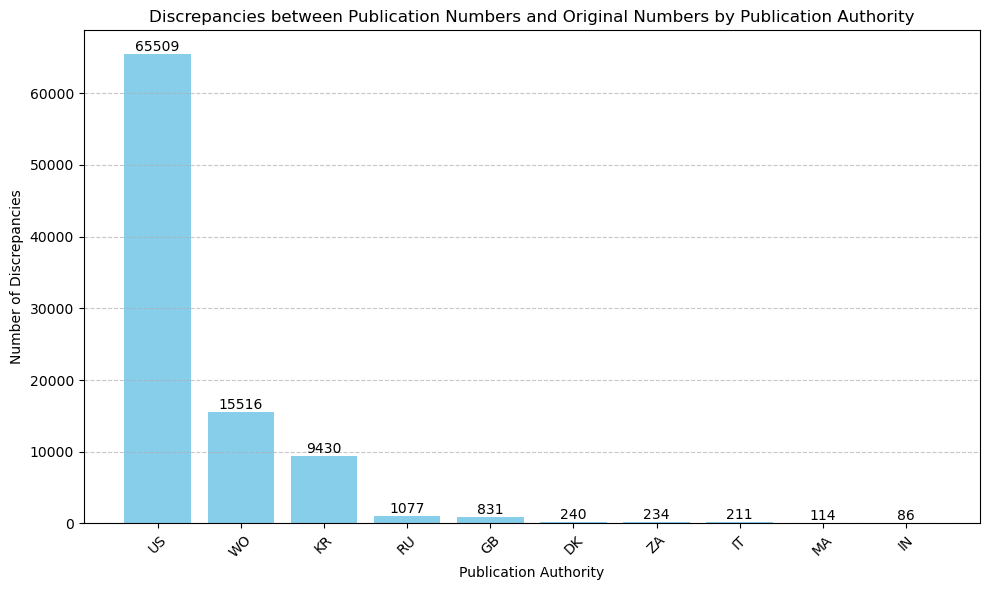

In [8]:
plt.figure(figsize=(10, 6))
bars = plt.bar(
    trend_analysis["publn_auth"], trend_analysis["discrepancy_count"], color="skyblue"
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',  # Display the height as an integer
        ha="center",
        va="bottom",
    )

plt.title(
    "Discrepancies between Publication Numbers and Original Numbers by Publication Authority"
)
plt.xlabel("Publication Authority")
plt.ylabel("Number of Discrepancies")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [9]:
publication_matched_query = (
    db.query(
        TLS211_PAT_PUBLN.pat_publn_id,
        TLS211_PAT_PUBLN.publn_auth,
        TLS211_PAT_PUBLN.publn_nr,
        TLS211_PAT_PUBLN.publn_nr_original,
        TLS211_PAT_PUBLN.publn_date,
    )
    .filter(
        TLS211_PAT_PUBLN.publn_nr
        == TLS211_PAT_PUBLN.publn_nr_original  # Check for the ones that have the same
    )
    .order_by(TLS211_PAT_PUBLN.publn_nr)
)

publication_matched_res = patstat.df(publication_matched_query)

publication_matched_res

,pat_publn_id,publn_auth,publn_nr,publn_nr_original,publn_date
0,387314222,EA,000588,000588,1999-12-29
1,310875510,EP,0008173,0008173,1980-02-20
2,310729854,EP,0013870,0013870,1980-08-06
3,387317837,EA,004201,004201,2004-02-26
4,387318789,EA,005152,005152,2004-12-30
...,...,...,...,...,...
272913,597958912,JP,WO2023053847,WO2023053847,2023-04-06
272914,601132860,JP,WO2023105551,WO2023105551,2023-06-15
272915,603445212,JP,WO2023139714,WO2023139714,2023-07-27
272916,604697250,JP,WO2023152862,WO2023152862,2023-08-17


In [10]:
matched_trend_analysis = (
    publication_matched_res.groupby("publn_auth")
    .size()
    .reset_index(name="matching_count")
)

matched_trend_analysis = matched_trend_analysis.sort_values(
    by="matching_count", ascending=False
).head(10)

matched_trend_analysis

,publn_auth,matching_count
9,CN,185889
19,EP,25823
59,US,18022
33,JP,9659
14,DE,6312
20,ES,3595
6,CA,3080
34,KR,2776
15,DK,2775
2,AU,2306


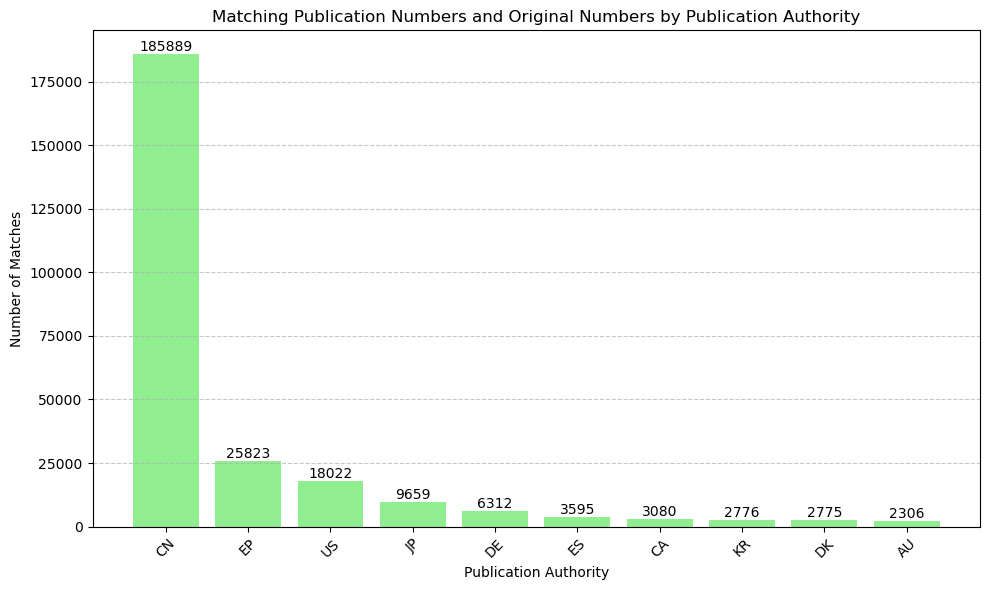

In [11]:
plt.figure(figsize=(10, 6))
bars = plt.bar(
    matched_trend_analysis["publn_auth"], matched_trend_analysis["matching_count"], color="lightgreen"
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',  # Display the height as an integer
        ha="center",
        va="bottom",
    )

plt.title(
    "Matching Publication Numbers and Original Numbers by Publication Authority"
)
plt.xlabel("Publication Authority")
plt.ylabel("Number of Matches")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### PUBLN_KIND

The publication kind indicates the **type** or **format** of the published patent document. It is represented by a specific code that signifies whether the document is an application, a granted patent, or another type of publication (e.g., a search report). Understanding the publication kind is critical for interpreting the content and implications of the patent document. For example, in EPO publications, an application publication (A1, A2) provides different information compared to a granted patent (B1, B2). The publication kind code helps researchers and legal professionals quickly determine the document's relevance and legal status within the patent landscape.

In [12]:
kind_codes_query = (
    db.query(
        TLS211_PAT_PUBLN.publn_kind,
        func.count(TLS211_PAT_PUBLN.pat_publn_id).label("count"),
    )
    .group_by(TLS211_PAT_PUBLN.publn_kind)
    .order_by(func.count(TLS211_PAT_PUBLN.pat_publn_id).desc())
)

kind_codes_res = patstat.df(kind_codes_query)

kind_codes_res

,publn_kind,count
0,A,141371
1,A1,106522
2,B,54250
3,B2,51918
4,U,46431
...,...,...
67,P2,1
68,P4,1
69,T9,1
70,X2,1


#### **STANDARD ST.16 - WIPO**

Here the **RECOMMENDED STANDARD CODE FOR THE IDENTIFICATION OF DIFFERENT KINDS OF PATENT DOCUMENTS** is insert, so that people can orient themselves thorugh the different ``PUBLN_KIND`` that exist. 
The Standard ST.16 outlines the recommended letter codes used to identify different kinds of patent documents published by industrial property offices. This classification is essential for the systematic organization and retrieval of patent-related documents. 

The letter codes are designed to distinguish various patent documents, including those derived from patent applications and non-patent literature. 

##### First Group

Includes primary patent documents (e.g., A, B, C). Use for documents resulting from a patent application and being identified as the primary or major series (excluding the utility model documents of Group 2 and the special series of patent documents as specified in Group 3, below).

- A - First publication level:
    -  This code indicates that the document represents the first publication of a patent application. This is the initial public disclosure of the application, which typically occurs 18 months after the priority date or filing date, depending on the jurisdiction. 
- B - Second publication level:
    - This code signifies a subsequent publication of a patent application. This may occur if the application undergoes significant changes or amendments after its initial filing and is re-published to reflect those changes.
- C - Third publication level:
    - This code indicates yet another level of publication, typically related to further amendments or additional disclosures regarding the patent application.
 
##### Second Group

Focuses on utility model documents, distinguishing between first, second, and third publication levels (U, Y, Z). Use for utility model documents having a numbering series other than the documents of Group:  

- U - First publication level
- Y - Second publication level
- Z - Third publication level.

##### Third Group

Indicates another level of publication, typically related to further amendments or additional disclosures regarding the patent application: 

- M - Medicament patent documents (e.g., documents previously published by FR)
- P - Plant patent documents (e.g., published by US)
- S - Design patent documents (e.g., published by US).

##### Fourth Group 

Used for special types of patent documents or documents derived from/relating to patent applications and not covered by Groups 1 to 3: 

- L - Documents, not covered by the letter code W, relating to patent documents and containing bibliographic information and only the text of an abstract and/or claim(s) and, where appropriate, a drawing
- R - Separately published search reports
- T - Publication, for information or other purposes, of the translation of the whole or part of a patent  document already published by another office or organisation
- W - Documents relating to utility model documents falling in Group 2 and containing bibliographic  information and only the text of an abstract and/or claim(s) and, where appropriate, a drawing.

##### Fifth Group

Covers a series of patent documents not covered by Groups 1 to 4: 

- E - First publication level
- F - Second publication level
- G - Third publication level.

##### Sixth Group

Documents derived from/relating to patent applications and not covered by Groups 1 to 5, above, according to the special requirements of each industrial property office (H and I)

##### Seventh Group 

Others: 

- N Non-patent literature documents
- X Documents restricted to the internal use of industrial property offices



#### **Weekly updated coverage, codes and statistics - Publication, application, priority numbers concordance table** 

The different kind codes used by various states are updated weekly and can be freely consulted on the following site: [Kind Codes Updates](https://publication-bdds.apps.epo.org/raw-data/products/public/product/31).



### PUBLN_DATE

The publication date is the date on which the patent document is **officially published** and made available to the public. This date is critical in the patent lifecycle as it marks the moment when the patent application enters the public domain.

#### Retrieve Publications for a Specific Application

Here it can be seen how to query the publications for a specific application, for example, with ``APPLN_ID``: **15806316**

In [13]:
query_publications_for_application = (
    db.query(
        TLS201_APPLN.appln_nr,
        TLS211_PAT_PUBLN.publn_nr,
        TLS211_PAT_PUBLN.publn_auth,
        TLS211_PAT_PUBLN.pat_publn_id,
        TLS211_PAT_PUBLN.publn_kind,
        TLS211_PAT_PUBLN.publn_date,
    )
    .join(TLS201_APPLN, TLS211_PAT_PUBLN.appln_id == TLS201_APPLN.appln_id)
    .filter(TLS201_APPLN.appln_id == 15806316)  # Filter for the specific application ID
    .order_by(TLS211_PAT_PUBLN.publn_date)  # Order publications by publication date
)

publications_for_application_res = patstat.df(query_publications_for_application)
publications_for_application_res

,appln_nr,publn_nr,publn_auth,pat_publn_id,publn_kind,publn_date
0,01105573,1150039,EP,290717146,A2,2001-10-31
1,01105573,1150039,EP,387566930,A3,2003-03-12
2,01105573,1150039,EP,290717149,B1,2003-11-12
3,01105573,1150039,EP,290717156,B2,2007-11-14
4,01105573,1150039,EP,331998793,B3,2011-02-09


The dataframe displays information regarding European patent publications (``publn_auth`` = EP) for a specific application, identified by the application number (``appln_nr``) and linked to various publications through the publication number (``publn_nr``). Each publication has associated attributes, including the publication authority (``publn_auth``), the unique patent publication ID (``pat_publn_id``), the publication kind (``publn_kind``), and the publication date (``publn_date``).

The European Patent Office (EPO) categorises its documents into two main types: **EP-A documents** and **EP-B documents**, each with distinct identifiers that indicate the nature of the publication.

**EP-A Documents:**

These are the initial publications of patent applications that provide information about the filing and associated search reports.

- **A1**: European patent application published with the European search report. This indicates that a search report has been made available alongside the publication.

- **A2**: European patent application published without the European search report. This indicates that at the time of publication, the search report was not available.

- **A3**: This refers to a separate publication of the European search report itself, allowing access to the search findings without the full application details.

- **A4**: Represents a supplementary search report, which provides additional insights following the initial search.

- **A8**: Indicates a corrected title page of a document, such as A1 or A2, which rectifies any inaccuracies.

- **A9**: Represents a complete reprint of a previously published document (A1, A2, or A3), ensuring that all details are accurately presented.


**EP-B Documents:**

These publications detail the specifications of granted patents and any changes following the opposition procedures.

- **B1**: This is a European patent specification that has been granted, indicating that the application has successfully completed the examination process.

- **B2**: This refers to a new European patent specification that has been amended following an opposition procedure, reflecting changes made to the initial granted patent.

- **B3**: Represents a European patent specification that has been amended following a limitation procedure, indicating a reduction in the scope of the patent claims.

- **B8**: Indicates a corrected title page of a B document (B1 or B2), ensuring all information is accurate and up-to-date.

- **B9**: This is a complete reprint of a B document (B1 or B2), which ensures that all details are correctly represented.

In this notebook, we will focus on analysing the kind codes that have the European Patent Office as their publication authority. By doing so, we aim to elucidate the underlying dynamics associated with these kind codes. This approach can subsequently be applied to other jurisdictions and their respective kind codes, enabling a comparative understanding of patent publication practices across different regions.

### PUBLN_LG

This attribute indicates the **language** in which the patent publication is made. It is important for understanding the accessibility of the publication to different linguistic demographics and for determining the audience that can engage with the document.

To gather insights about the different languages used in patent publications, we can create a query that counts the number of publications by each language:

In [14]:
publication_language_query = (
    db.query(
        TLS211_PAT_PUBLN.publn_lg.label("publication_language"),
        func.count(TLS211_PAT_PUBLN.pat_publn_id).label("number_of_publications"),
    )
    .group_by(TLS211_PAT_PUBLN.publn_lg)  # Group by publication language
    .order_by(func.count(TLS211_PAT_PUBLN.pat_publn_id).desc())
    .limit(10)
)

publication_language_res = patstat.df(publication_language_query)

publication_language_res

,publication_language,number_of_publications
0,ZH,190847
1,EN,157169
2,,52703
3,DE,17735
4,KO,13148
5,JA,11151
6,ES,5311
7,FR,3670
8,RU,2819
9,DA,2806


### PUBLN_FIRST_GRANT

This attribute indicates whether the publication marks the **first indication of a patent grant**. It essentially flags the publication as a significant milestone in the patent's lifecycle.
This field can have two possible values:

- **Y** (Yes): This indicates that the publication represents the first indication of a patent grant for that application. It signifies that the application has successfully transitioned to a granted patent status for the first time.

- **N** (No): This signifies that the publication does not represent the first grant. In this case, the patent may have undergone modifications, amendments, or subsequent grants, and this publication is not the initial grant of the patent application.

The first grant publication is crucial because it represents the point at which the patent's rights are officially recognised. Analysing these publications can help track the effectiveness of patent applications and the timeliness of granting processes. It may also provide insights into the applicant’s strategic decisions regarding when to file for patent protection. The **Y** and **N** values allow analysts to trace the lifecycle of patent applications. Recognising which publications are first grants can help assess the timing of patent grants in relation to application submissions.

In [15]:
query_first_grant = db.query(
    TLS211_PAT_PUBLN.pat_publn_id,
    TLS211_PAT_PUBLN.publn_auth,
    TLS211_PAT_PUBLN.publn_nr,
    TLS211_PAT_PUBLN.publn_date,
    TLS211_PAT_PUBLN.publn_first_grant,
).order_by(TLS211_PAT_PUBLN.publn_first_grant)

first_grant_res = patstat.df(query_first_grant)

first_grant_res

,pat_publn_id,publn_auth,publn_nr,publn_date,publn_first_grant
0,277463601,JP,2007335157,2007-12-27,N
1,277470751,CN,101257214,2008-09-03,N
2,278075478,JP,2008101363,2008-05-01,N
3,278095305,JP,2008090548,2008-04-17,N
4,282661042,JP,2005023613,2005-01-27,N
...,...,...,...,...,...
461900,529676661,DK,201900085,2020-04-14,Y
461901,542048852,DK,202000105,2020-11-27,Y
461902,542436114,DK,202000107,2020-12-04,Y
461903,595358053,DK,202200058,2023-07-03,Y


It is interesting to analyse the average number of days that each authority takes from the application filing date to the first grant. Understanding the time taken by different patent authorities to grant patents provides valuable insights into the efficiency and responsiveness of their respective patent systems.

In [16]:
first_grant_time_query = (
    db.query(
        TLS201_APPLN.appln_nr,
        TLS211_PAT_PUBLN.pat_publn_id,
        TLS211_PAT_PUBLN.publn_auth,
        TLS211_PAT_PUBLN.publn_nr,
        TLS211_PAT_PUBLN.publn_nr_original,
        TLS211_PAT_PUBLN.publn_date,
        TLS201_APPLN.appln_filing_date,
        (TLS211_PAT_PUBLN.publn_date - TLS201_APPLN.appln_filing_date).label(
            "days_to_first_grant"
        ),  # Subtract dates directly
    )
    .join(TLS201_APPLN, TLS211_PAT_PUBLN.appln_id == TLS201_APPLN.appln_id)
    .filter(
        TLS211_PAT_PUBLN.publn_first_grant == "Y",
        TLS201_APPLN.appln_filing_date != "9999-12-31",
    )
    .order_by((TLS211_PAT_PUBLN.publn_date - TLS201_APPLN.appln_filing_date).asc())
)

first_grant_time_res = patstat.df(first_grant_time_query)

first_grant_time_res

,appln_nr,pat_publn_id,publn_auth,publn_nr,publn_nr_original,publn_date,appln_filing_date,days_to_first_grant
0,2026718,552081796,NL,2026718,None,2020-06-04,2020-10-21,"(0, -139, 0)"
1,202022103411,576265066,DE,202022103411,202022103411,2022-06-23,2022-06-19,"(0, 4, 0)"
2,202018101002,492134986,DE,202018101002,202018101002,2018-02-28,2018-02-22,"(0, 6, 0)"
3,202021102426,551429718,DE,202021102426,202021102426,2021-05-11,2021-05-05,"(0, 6, 0)"
4,202022103398,576264962,DE,202022103398,202022103398,2022-06-23,2022-06-17,"(0, 6, 0)"
...,...,...,...,...,...,...,...,...
208073,9104319,339782164,GB,2476787,2476787,2011-12-07,1991-03-01,"(0, 7586, 0)"
208074,27971052,327932689,US,3784983,None,1974-01-08,1952-03-31,"(0, 7953, 0)"
208075,41319073,294270975,US,5926128,None,1999-07-20,1973-11-01,"(0, 9392, 0)"
208076,22569981,421617606,US,8830112,08830112,2014-09-09,1981-01-16,"(0, 12289, 0)"


In [17]:

first_grant_time_res['days_to_first_grant'] = first_grant_time_res['days_to_first_grant'].apply(lambda x: x[1])    # Extract the number of days from the 'days_to_first_grant' tuple

average_days_to_first_grant = (
    first_grant_time_res.groupby("publn_auth")["days_to_first_grant"]
    .mean()
    .reset_index()
)

average_days_to_first_grant.columns = ["publn_auth", "avg_days_to_first_grant"]    # Rename the columns for clarity

average_days_to_first_grant['avg_days_to_first_grant'] = average_days_to_first_grant['avg_days_to_first_grant'].round(2)    # Round the average days to two decimal places 

top_10_average_days_to_first_grant = average_days_to_first_grant.sort_values(
    by="avg_days_to_first_grant"
).head(10)

top_10_average_days_to_first_grant = top_10_average_days_to_first_grant.reset_index(drop=True) 

top_10_average_days_to_first_grant

,publn_auth,avg_days_to_first_grant
0,SM,37.00
1,NI,140.00
2,PH,150.13
3,SI,277.00
4,LU,311.98
5,AR,401.00
6,GR,407.33
7,BE,454.06
8,ZA,481.98
9,BG,568.22


The query demonstrates that when a patent is granted under the EPO, B1 is the kind code used to denote this status, as indicated by the ``PUBLN_FIRST_GRANT = 'Y'`` condition. This kind of check helps confirm the standard codes associated with patent grants.

In [18]:
distinct_kindcode_query = (
    db.query(TLS211_PAT_PUBLN.publn_kind)
    .filter(
        TLS211_PAT_PUBLN.publn_first_grant == "Y", TLS211_PAT_PUBLN.publn_auth == "EP"
    )
    .distinct()
)

distinct_kindcode_res = patstat.df(distinct_kindcode_query)

distinct_kindcode_res

,publn_kind
0,B1


### PUBLN_CLAIMS

``PUBLN_CLAIMS`` in the ``TLS211_PAT_PUBLN`` table refers to the number of claims listed in a specific patent publication. Claims are a crucial part of a patent document because they define the **scope of the patent's protection**, detailing the boundaries of the intellectual property that the patent covers. By looking at the number of claims, one can understand how broad or narrow the protection of the invention is. More claims might indicate a more comprehensive protection of various aspects of the invention.

The number of claims can indicate the **complexity** and **breadth** of the patent. A higher number of claims may suggest a more comprehensive coverage of the invention, which can be strategically beneficial for the applicant. Analysing claim counts across different patents can also highlight trends in innovation within certain industries or technology fields.

In [19]:
claims_changes_query = (
    db.query(
        TLS201_APPLN.appln_nr,
        TLS211_PAT_PUBLN.publn_auth,
        TLS211_PAT_PUBLN.publn_nr,
        TLS211_PAT_PUBLN.publn_kind,
        TLS211_PAT_PUBLN.publn_date,
        TLS211_PAT_PUBLN.publn_claims,
    )
    .filter(
        TLS201_APPLN.appln_id == 15806316  # Filter for the specific application number
    )
    .join(TLS211_PAT_PUBLN, TLS201_APPLN.appln_id == TLS211_PAT_PUBLN.appln_id)
    .order_by(TLS211_PAT_PUBLN.publn_date)
)

claims_changes_res = patstat.df(claims_changes_query)
claims_changes_res

,appln_nr,publn_auth,publn_nr,publn_kind,publn_date,publn_claims
0,01105573,EP,1150039,A2,2001-10-31,10
1,01105573,EP,1150039,A3,2003-03-12,0
2,01105573,EP,1150039,B1,2003-11-12,10
3,01105573,EP,1150039,B2,2007-11-14,10
4,01105573,EP,1150039,B3,2011-02-09,10


Throughout the lifecycle of a publication, the number of claims associated with a patent can vary significantly. This variability may result in certain publications, such as those designated with kind code A3, having zero claims at certain points.

For example, publications categorised under A3 typically refer to separate publications of the European search report. These documents may not include any claims, reflecting their specific purpose of disclosing search results rather than outlining patent rights. Consequently, the claims for these publications can appear as zero, particularly if they are standalone documents that do not represent the complete patent application.

It is valuable to examine the **average number of claims** across different stages of European patent publications. By focusing on publications with kind codes A1 and A2, which represent the initial stages of a patent application, and comparing these to the B1 publications, which signify granted patents, we gain insights into the evolution of patent scope over the patenting process.

In [20]:
average_claims_A1_A2_query = db.query(
    func.avg(TLS211_PAT_PUBLN.publn_claims).label('avg_claims_A1_A2')
).filter(
    TLS211_PAT_PUBLN.publn_auth == 'EP',  
    TLS211_PAT_PUBLN.publn_kind.in_(['A1', 'A2'])  
)

average_claims_A1_A2_res = patstat.df(average_claims_A1_A2_query)

average_claims_A1_A2_res

,avg_claims_A1_A2
0,8.429957


These represent **initial patent applications** published by the European Patent Office, with **A1** including the European search report and A2 without it. Analysing the average number of claims in these stages helps identify how inventors define the scope of their inventions early in the process.

In [21]:
average_claims_B1_query = db.query(
    func.avg(TLS211_PAT_PUBLN.publn_claims).label('avg_claims_B1')
).filter(
    TLS211_PAT_PUBLN.publn_auth == 'EP',  
    TLS211_PAT_PUBLN.publn_kind == 'B1'  
)

average_claims_B1_res = patstat.df(average_claims_B1_query)

average_claims_B1_res

,avg_claims_B1
0,12.020827


The **B1** publication reflects the **granted patent**, often following examination and potential modifications. By comparing the average number of claims at this stage with the initial A1/A2 stages, we can see how the scope of the patent evolves. It’s common for the number of claims to be reduced during the examination process due to legal and technical objections.